In [1]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
from google.colab.patches import cv2_imshow

In [2]:
# Run this command only once:

# makes the output folder /content/pictures/
!mkdir pictures

In [3]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 84.3MB/s]


In [ ]:
# path = "/content/"

# NUMBER_OF_PLATES = 200

# # Generate NUMBER_OF_PLATES with random values of the form CC NN (C: character
# # N: number)

# for i in range(0, NUMBER_OF_PLATES):

#     # Pick two random letters
#     plate_alpha = ""
#     for _ in range(0, 2):
#         plate_alpha += (random.choice(string.ascii_uppercase))

#     # Pick two random numbers
#     num = randint(0, 99)
#     plate_num = "{:02d}".format(num)

#     # Write plate to image
#     blank_plate = cv2.imread(path+'blank_plate.png')

#     # Convert into a PIL image (this is so we can use the monospaced fonts)
#     blank_plate_pil = Image.fromarray(blank_plate)

#     # Get a drawing context
#     draw = ImageDraw.Draw(blank_plate_pil)
#     monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf",
#                                    size=165)
#     draw.text(xy=(48, 75),
#               text=plate_alpha + " " + plate_num,
#               fill=(255,0,0), font=monospace)

#     # Convert back to OpenCV image and save
#     blank_plate = np.array(blank_plate_pil)

#     # Write license plate to file
#     cv2.imwrite(os.path.join(path + "pictures/",
#                              "plate_{}{}.png".format(plate_alpha, plate_num)),
#                              blank_plate)

In [ ]:
# import os
# import cv2
# import random
# import string
# import numpy as np
# from PIL import Image, ImageDraw, ImageFont
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define paths
# path = "/content/"
# pictures_path = os.path.join(path, "pictures/")
# os.makedirs(pictures_path, exist_ok=True)

# NUMBER_OF_PLATES = 200

# # Initialize the data generator with augmentations
# datagen = ImageDataGenerator(
#     rotation_range=8,            # Random rotation within 5 degrees
#     zoom_range=0.05,             # Small random zoom (1%)
#     brightness_range=[0.3, 2.0], # Adjust brightness between 50% and 200%
#     shear_range=2,               # Shear by 2 degrees
#       width_shift_range=0.05,       # Shift width by 10%
#     height_shift_range=0.05       # Shift height by 10%
# )

# # Generate NUMBER_OF_PLATES with random values
# for i in range(0, NUMBER_OF_PLATES):
#     # Pick two random letters
#     plate_alpha = ""
#     for _ in range(0, 2):
#         plate_alpha += random.choice(string.ascii_uppercase)

#     # Pick two random numbers
#     num = random.randint(0, 99)
#     plate_num = "{:02d}".format(num)

#     # Write plate to image
#     blank_plate = cv2.imread(path + 'blank_plate.png')

#     # Convert into a PIL image (this is so we can use the monospaced fonts)
#     blank_plate_pil = Image.fromarray(blank_plate)

#     # Get a drawing context
#     draw = ImageDraw.Draw(blank_plate_pil)
#     monospace = ImageFont.truetype(
#         font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf",
#         size=165
#     )
#     draw.text(
#         xy=(48, 75),
#         text=plate_alpha + " " + plate_num,
#         fill=(255, 0, 0),  # Red text color
#         font=monospace
#     )

#     # Convert back to OpenCV image
#     blank_plate = np.array(blank_plate_pil)

#     # Expand dimensions to match the generator's input format (batch size, height, width, channels)
#     blank_plate = np.expand_dims(blank_plate, axis=0)

#     # Apply augmentations using the generator
#     augmented_iter = datagen.flow(blank_plate, batch_size=1)

#     # Get the augmented image
#     value = next(augmented_iter)  # Get the first (and only) batch
#     augmented_image = value[0].astype('uint8')  # Convert back to uint8

#     # Save the augmented plate image
#     cv2.imwrite(os.path.join(
#         pictures_path,
#         f"plate_{plate_alpha}{plate_num}.png"
#     ), augmented_image)


In [5]:
import os
import cv2
import random
import string
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
path = "/content/"
pictures_path = os.path.join(path, "pictures/")
os.makedirs(pictures_path, exist_ok=True)

NUMBER_OF_PLATES = 499
# Initialize the data generator with augmentations
datagen = ImageDataGenerator(
    rotation_range=8,            # Random rotation within 8 degrees
    zoom_range=0.05,             # Small random zoom (5%)
    brightness_range=[0.8, 2.0], # Adjust brightness between 30% and 200%
    shear_range=2,               # Shear by 2 degrees
    width_shift_range=0.05,      # Shift width by 5%
    height_shift_range=0.05      # Shift height by 5%
)

def blue_mask(image):
    # Convert the image from BGR to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for blue in HSV
    lower_blue = np.array([100, 120, 70])  # Lower range for blue
    upper_blue = np.array([140, 255, 255])  # Upper range for blue

    # Create a binary mask where blue pixels are 1 and others are 0
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

    return blue_mask
# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=25):
    gauss = np.random.normal(mean, std, image.shape)  # Generate Gaussian noise
    noisy_image = image + gauss  # Add noise
    noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')  # Clip to valid range
    return noisy_image

# Function to add Salt-and-Pepper noise
def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = image.copy()
    total_pixels = image.size

    # Add salt (white pixels)
    num_salt = int(salt_prob * total_pixels)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1]] = 255

    # Add pepper (black pixels)
    num_pepper = int(pepper_prob * total_pixels)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1]] = 0

    return noisy_image

# Function to add Gaussian blur
def add_gaussian_blur(image, kernel_size=(10, 50)):
    """
    Applies Gaussian blur to the image.
    Args:
        image: Input image (NumPy array).
        kernel_size: Tuple representing the size of the Gaussian kernel.
    Returns:
        Blurred image (NumPy array).
    """
    blurred_image = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred_image

# Generate NUMBER_OF_PLATES with random values
for i in range(0, NUMBER_OF_PLATES):
    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += random.choice(string.ascii_uppercase)

    # Pick two random numbers
    num = random.randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path + 'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(
        font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf",
        size=165
    )
    draw.text(
        xy=(48, 75),
        text=plate_alpha + " " + plate_num,
        fill=(255, 0, 0),  # Red text color
        font=monospace
    )

    # Convert back to OpenCV image
    blank_plate = np.array(blank_plate_pil)

    # Expand dimensions to match the generator's input format (batch size, height, width, channels)
    blank_plate = np.expand_dims(blank_plate, axis=0)

    # Apply augmentations using the generator
    augmented_iter = datagen.flow(blank_plate, batch_size=1)

    # Get the augmented image
    value = next(augmented_iter)  # Get the first (and only) batch
    augmented_image = value[0].astype('uint8')  # Convert back to uint8

    augmented_image = add_gaussian_noise(augmented_image)

    augmented_image = add_salt_and_pepper_noise(augmented_image)

    augmented_image = add_gaussian_blur(augmented_image, kernel_size=(5, 5))

    augmented_image = blue_mask(augmented_image)


    # Save the augmented plate image with noise or blur
    cv2.imwrite(os.path.join(
        pictures_path,
        f"plate_{plate_alpha}{plate_num}.png"
    ), augmented_image)


In [6]:
import os

# Specify the directory you want to count the files in
directory = '/content/pictures/'

# List all files and directories in the specified directory
all_files = os.listdir(directory)

# Filter only files (ignoring directories)
file_count = len([f for f in all_files if os.path.isfile(os.path.join(directory, f))])

print(f"Number of files in the directory: {file_count}")

Number of files in the directory: 989


In [6]:
!gdown 18TBwgykqhpCoyn6Sf6lV_-MplhIP9R5d
!unzip /content/test_pictures.zip

Downloading...
From: https://drive.google.com/uc?id=18TBwgykqhpCoyn6Sf6lV_-MplhIP9R5d
To: /content/test_pictures.zip
100% 16.6M/16.6M [00:00<00:00, 71.7MB/s]
Archive:  /content/test_pictures.zip
   creating: test_pictures/
  inflating: test_pictures/plate_AR20.png  
  inflating: test_pictures/plate_AT48.png  
  inflating: test_pictures/plate_AX07.png  
  inflating: test_pictures/plate_BJ61.png  
  inflating: test_pictures/plate_BR26.png  
  inflating: test_pictures/plate_BR36.png  
  inflating: test_pictures/plate_BT43.png  
  inflating: test_pictures/plate_BY61.png  
  inflating: test_pictures/plate_CC68.png  
  inflating: test_pictures/plate_CS82.png  
  inflating: test_pictures/plate_CU90.png  
  inflating: test_pictures/plate_CV48.png  
  inflating: test_pictures/plate_CW47.png  
  inflating: test_pictures/plate_DY60.png  
  inflating: test_pictures/plate_EP68.png  
  inflating: test_pictures/plate_ER19.png  
  inflating: test_pictures/plate_ER61.png  
  inflating: test_pictures/pl

In [7]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [8]:
# Load image:
image_path = '/content/pictures/plate_AB08.png'
# Create an array with a single image (we need it for the iterator)
image_array = np.expand_dims(Image.open(image_path), 0)

In [9]:
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.05,
                             brightness_range=[0.2, 2.0])

In [10]:
NUM_IMAGES_TO_GENERATE = 1

datagen_iterator = datagen.flow(image_array, batch_size=1)

for j in range(NUM_IMAGES_TO_GENERATE):
  value = next(datagen_iterator)
  img = value[0].astype('uint8')
  plt.imshow(img)

ValueError: Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape (1, 298, 600)

This is the algorithm that we use to create cropped images of each letter

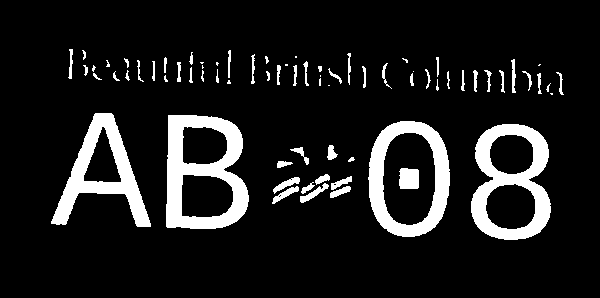

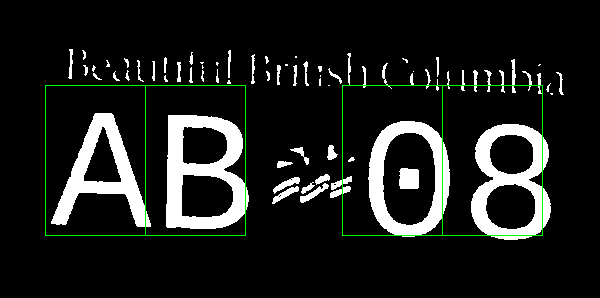

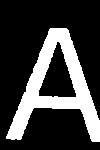

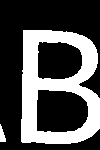

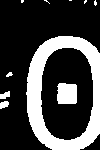

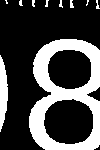

In [12]:
# Read the plate image
plate = cv2.imread('/content/pictures/plate_AB08.png')

# Display the original plate image
cv2_imshow(plate)

# Make a copy of the plate image
plate_copy = plate.copy()

# Define rectangle dimensions
rect_width = 100  # Width of each rectangle
rect_height = 150  # Height of each rectangle

# Define the starting position for the first character and middle width (gap between some characters)
left_start = (45, 85)  # Starting point
middle_width = 97  # Gap between certain characters

# Define character bounding boxes (I hard-coded this, it is painful)
char1 = (left_start, (left_start[0] + rect_width, left_start[1] + rect_height))
char2 = ((char1[1][0], left_start[1]), (char1[1][0] + rect_width, left_start[1] + rect_height))
char3 = ((char2[1][0] + middle_width, left_start[1]), (char2[1][0] + rect_width + middle_width, left_start[1] + rect_height))
char4 = ((char3[1][0], left_start[1]), (char3[1][0] + rect_width, left_start[1] + rect_height))

# Collect the character rectangles in a list
rectangles = [char1, char2, char3, char4]

# Draw the rectangles on the copied image
for (top_left, bottom_right) in rectangles:
    cv2.rectangle(plate_copy, top_left, bottom_right, (0, 255, 0), 1)  # Green rectangles, thickness=1

# Display the modified image with rectangles
cv2_imshow(plate_copy)

# Initiate array to store images
cropped_plate = []
for i, (top_left, bottom_right) in enumerate(rectangles):
    # Crop each rectangle
    # top_left[1]:bottom_right[1] is range of rows (height)
    # top_left[0]:bottom_right[0] is range of column (width)
    cropped_image = plate[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    cropped_plate.append(cropped_image)

    # Save each cropped image
    cv2.imwrite(f'cropped_char_{i+1}.png', cropped_image)

    # Optionally display the cropped image
    cv2_imshow(cropped_image)





We create functions for One-hot Encoding, Cropping license Plate, and Processing the Images

In [18]:

# Define character set for one-hot encoding (0-9 and A-Z)
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Match the character to its location in string characters
char_to_onehot = {char: i for i, char in enumerate(characters)}


"""
One-hot Encoding
- We create a 36 letter vector
- Match each character to a vector
"""
# Encode a specific character to a vector
def one_hot_encode(char):
    one_hot = np.zeros(36)  # 36-dimensional vector
    one_hot[char_to_onehot[char]] = 1  # Set the correct index to 1
    return one_hot

"""
Crop License Plate
- Use trial-and-error to find the correct bounds for each character
- Crop each rectangle and
"""
# Crop the license plate by each letter into 4 equal images
def crop_license_plate(image, char_width=100, char_height=150, left_start=(45, 85), middle_width=97):

    # Define the corners for each character region
    char1 = (left_start, (left_start[0] + char_width, left_start[1] + char_height))
    char2 = ((char1[1][0], left_start[1]), (char1[1][0] + char_width, left_start[1] + char_height))
    char3 = ((char2[1][0] + middle_width, left_start[1]), (char2[1][0] + char_width + middle_width, left_start[1] + char_height))
    char4 = ((char3[1][0], left_start[1]), (char3[1][0] + char_width, left_start[1] + char_height))

    # Draw 4 rectangles
    rectangles = [char1, char2, char3, char4]

    # Initiate array to store the cropped images
    cropped_images = []

    # Crop the 4 rectangles
    for top_left, bottom_right in rectangles:
        cropped_image = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        cropped_image_resized = cv2.resize(cropped_image, (char_width, char_height))
        # Save into array
        cropped_images.append(cropped_image_resized)

    return cropped_images

"""
Process the Images
- We iterate through each image in the directory
- Crop each image into 4 rectangles, one character per image
- Match the name of the license plate to each cropped character
- Create training data ourselves
"""

def process_license_plate_files(directory):
    X_data = []  # Will store all cropped images (input for CNN)
    Y_data = []  # Will store all one-hot encoded labels

    # Iterate over each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.png'):  # Only process PNG files
            # Get the path to the image
            image_path = os.path.join(directory, filename)

            # Extract the file name by splitting it at '_' and '.'
            label = filename.split('_')[1].split('.')[0]  # "EP68"

            # Read the image
            plate_image = cv2.imread(image_path)
            # grayscale_image = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
            # _, binary_image = cv2.threshold(grayscale_image, 127, 255, cv2.THRESH_BINARY)
            # inverted_image = cv2.bitwise_not(binary_image)
            original_height, original_width = plate_image.shape[:2]


            # Downscale the image by a factor of 2
            downscaled_image = cv2.resize(plate_image,
                                          (original_width // 4, original_height // 4),
                                          interpolation=cv2.INTER_AREA)

            # Upscale the image back to its original size
            plate_image = cv2.resize(downscaled_image,
                                        (original_width, original_height),
                                        interpolation=cv2.INTER_LINEAR)

            # Crop the license plate into subsections by calling previous function
            cropped_images = crop_license_plate(plate_image)

            # One-hot encode the label and associate with each cropped image
            for i, char in enumerate(label):
                one_hot_label = one_hot_encode(char)  # One-hot encode each character
                X_data.append(cropped_images[i])      # Add cropped image to X_data
                Y_data.append(one_hot_label)          # Add one-hot label to Y_data

    # Convert lists to NumPy arrays for easier manipulation
    X_data = np.array(X_data)
    Y_data = np.array(Y_data)

    return np.array(X_data), np.array(Y_data)

We call the process license plate files function and see if we are correctly producing and matching the character to the one-hot encoder. The shape of X and Y can tell us how large our data library is.

X shape: (3956, 150, 100, 3)
Y shape: (3956, 36)


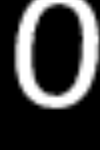

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


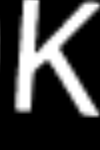

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


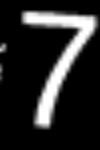

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


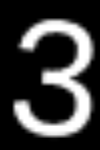

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


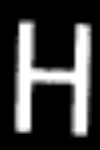

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
X_data, Y_data = process_license_plate_files('/content/pictures/')

# Print the shapes of X and Y
print(f"X shape: {X_data.shape}")  # Number of cropped images and their dimensions
print(f"Y shape: {Y_data.shape}")  # Number of one-hot encoded labels and their size

for i in range(5):  # Display the first 5 images to check if it is good
    cv2_imshow(X_data[i])
    print(Y_data[i])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 148, 98, 16)         │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 74, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 72, 47, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 36, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 34, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 17, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 15, 8, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 7, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3584)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 3584)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,835,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 36)                  │          18,468 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,951,428 (7.44 MB)

 Trainable params: 1,951,428 (7.44 MB)

 Non-trainable params: 0 (0.00 B)

112/112 ━━━━━━━━━━━━━━━━━━━━ 55s 482ms/step - acc: 0.0505 - loss: 35.6979 - val_acc: 0.1869 - val_loss: 3.0410


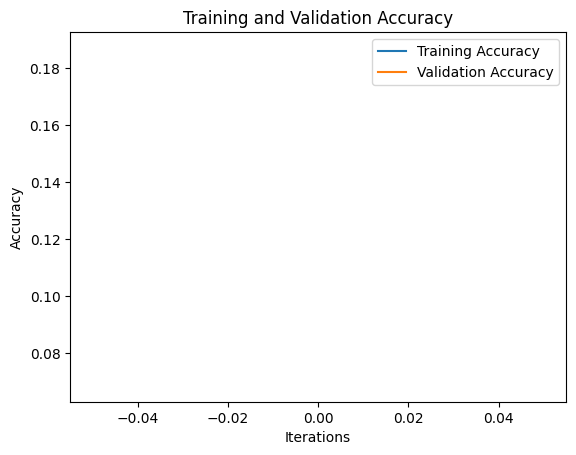

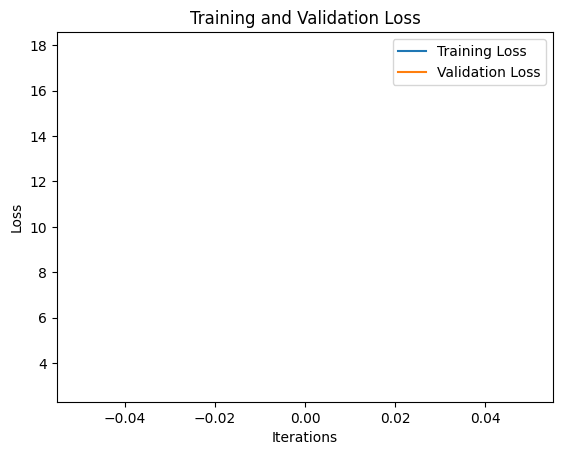

124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step


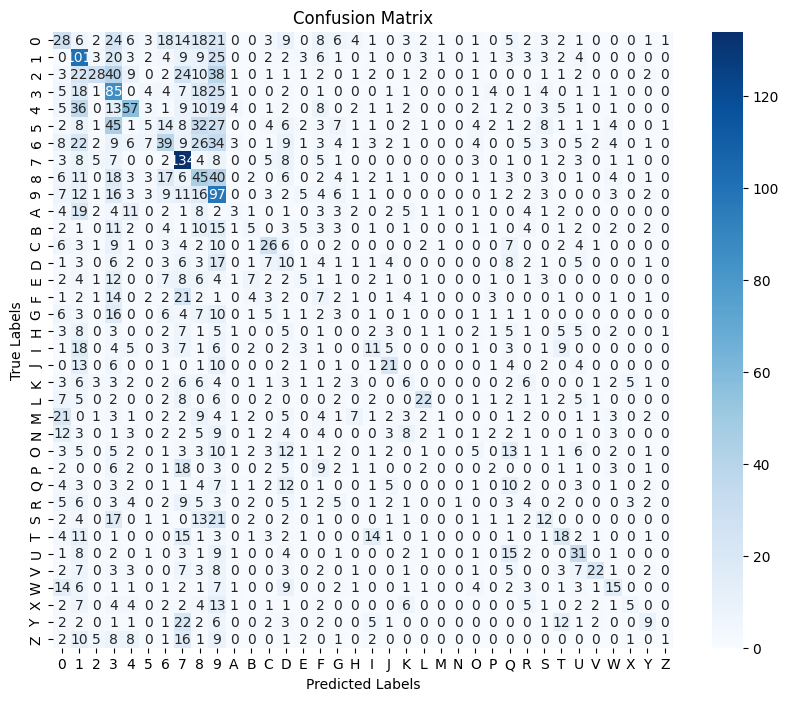

In [24]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

# Source: https://stackoverflow.com/questions/63435679
def reset_weights_tf2(model):

  # This loop iterates through each layer
  for ix, layer in enumerate(model.layers):
      # Check that there is 'kernel_initializer', 'bias_initializer'
      if (hasattr(model.layers[ix], 'kernel_initializer') and
          hasattr(model.layers[ix], 'bias_initializer')):
          # Finds weight & bias initializer
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          # Finds the current weights and biases
          old_weights, old_biases = model.layers[ix].get_weights()

          # Reinitializes weight and bias
          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])


conv_model = models.Sequential()
conv_model.add(layers.Conv2D(16, (3, 3), activation='relu',
                             input_shape=(150, 100, 3)))
conv_model.add(layers.MaxPooling2D((2, 2)))

conv_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))

conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))

conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))

conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
# conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(36, activation='softmax'))


conv_model.summary()

# Validation split: 10% of data will be used for validation
VALIDATION_SPLIT = 0.1

LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

reset_weights_tf2(conv_model)

# Batch size: How many samples will be processed in one step
# Samples: From your training data set
# Step size: Samples / Batch size
history_conv = conv_model.fit(np.array(X_data), np.array(Y_data),
                              validation_split=VALIDATION_SPLIT,
                              epochs=1,
                              batch_size= 32)

# Plot accuracy
plt.plot(history_conv.history['acc'], label='Training Accuracy')
plt.plot(history_conv.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_conv.history['loss'], label='Training Loss')
plt.plot(history_conv.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions
Y_pred = conv_model.predict(X_data)

# Convert predictions and true labels to class indices
Y_pred_labels = np.argmax(Y_pred, axis=1) # My predicted data
Y_true_labels = np.argmax(Y_data, axis=1) # Actual data we are matching

# Generate the confusion matrix
cm = confusion_matrix(Y_true_labels, Y_pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=characters, yticklabels=characters)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
conv_model.save('trained_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!python --version


Python 3.10.12


In [ ]:
!sudo apt-get update
!sudo apt-get install python3.8.10

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
!pip uninstall -y tensorflow tensorflow-estimator keras keras-preprocessing



Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0


In [ ]:
!pip install tensorflow==2.13.1 keras==2.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 25.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      Successfully uninstalled gast-0.6.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.1
    Uni

In [ ]:
!pip uninstall tensorflow -y

!python3 -m pip install tensorflow==2.13.1

Found existing installation: tensorflow 2.13.1
Uninstalling tensorflow-2.13.1:
  Successfully uninstalled tensorflow-2.13.1
  Using cached tensorflow-2.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached tensorflow-2.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (479.7 MB)


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.13.1
